In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

In [3]:
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import pystan
import tensorflow as tf

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
import tssimul
import tspred
import tspred_qtl
import rnn_analysis

In [7]:
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.linear_model import (LinearRegression,
                                  SGDClassifier)
from sklearn.decomposition import FastICA, PCA
from sklearn.ensemble import (RandomForestRegressor,
                              RandomForestClassifier)

In [8]:
burn_in = 50

# AR(1) 

Simulate samples

In [9]:
ar = [0.0868, 0.3667]
ma = [-0.1150, -0.4068]
sigma = .0112

In [10]:
simulation = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 'n')
simulation_test = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 'n')

In [11]:
simulation.shape, simulation_test.shape

((5000, 3, 1000), (5000, 3, 1000))

In [12]:
simulation_t = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 't', 4.5)
simulation_t_test = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 't', 4.5)

In [13]:
simulation_exp = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 'exp')
simulation_exp_test = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 'exp')

In [14]:
# np.savez_compressed('simulation', data=simulation)
# np.savez_compressed('simulation_test', data=simulation_test)

In [152]:
data = simulation_exp
data_test = simulation_exp_test

# Stochastic Volatility

Simulate samples

In [10]:
sv_beta = .98
sv_sigma = .168
sv_intercept = -3.926

In [11]:
sv, svvol = tssimul.simulate_sv(sv_beta, sv_sigma,
                                sv_intercept, (5000, 1000))
sv_test, svvol_test = tssimul.simulate_sv(sv_beta, sv_sigma,
                                          sv_intercept, (500, 1000))

In [12]:
stats.describe(sv.ravel())

DescribeResult(nobs=5000000, minmax=(-0.16251504124838245, 0.16889895057080634), mean=6.3666536513315898e-06, variance=0.00010975681166093846, skewness=0.008468034416795452, kurtosis=3.1227177163589674)

In [82]:
stats.describe(svvol.ravel())

DescribeResult(nobs=5000000, minmax=(0.018045324639038317, 1.1020478390646546), mean=0.15329274226257966, variance=0.0044917155658833405, skewness=1.4174405203109106, kurtosis=3.7752985793496885)

In [83]:
stats.describe(svvol.ravel() ** 2)

DescribeResult(nobs=5000000, minmax=(0.00032563374132828335, 1.214509439587075), mean=0.027990379497921915, variance=0.00080035720864075953, skewness=4.054450387095615, kurtosis=36.16007596911728)

In [84]:
stats.describe(svvol_test.ravel() ** 2)

DescribeResult(nobs=500000, minmax=(0.00035299657692129102, 0.89837317286388985), mean=0.027837523641173794, variance=0.00081043106975812117, skewness=4.255823225893204, kurtosis=39.43058636697476)

In [13]:
data = tssimul.simulate_arima_given_innov(ar, [], sv)
data_test = tssimul.simulate_arima_given_innov(ar, [], sv_test)

In [164]:
# np.savez_compressed(<file>, data=data, svvol=svvol)

# Regime-Switching Process

Simulate samples

In [37]:
rs_p0 = .8
rs_p00 = .9
rs_p10 = .2
rs_mu = [0, -.005]
rs_sigma = [.08, .3]
rs, rs_prob0, rs_regime = tssimul.simulate_rs(rs_p0, rs_p00,
                                              rs_p10, rs_mu,
                                              rs_sigma, (5000, 1000))
rs_test, rs_prob0_test, rs_regime_test = tssimul.simulate_rs(rs_p0,
                                                             rs_p00,
                                                             rs_p10,
                                                             rs_mu,
                                                             rs_sigma,
                                                             (500, 1000))

In [38]:
rs.shape, rs_prob0.shape, rs_regime.shape

((5000, 1000), (5000, 1000), (5000, 1000))

In [13]:
stats.describe(rs.ravel())

DescribeResult(nobs=5000000, minmax=(-0.10027182433879982, 0.1031418152339469), mean=-0.0016676499245161524, variance=0.00013972994882308483, skewness=-0.6644921381648347, kurtosis=3.8469821872161205)

In [13]:
np.sqrt(0.000139)

0.011789826122551595

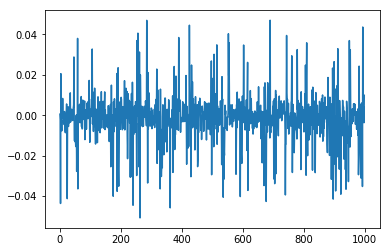

In [14]:
plt.plot(rs[75, :])

In [39]:
data = tssimul.simulate_arima_given_innov(ar, [], rs)
data_test = tssimul.simulate_arima_given_innov(ar, [], rs_test)

# Regression with RMSE Loss

In [15]:
sess = tf.Session()

In [16]:
simple_features = lambda x: x[:-1]

In [17]:
features_func = simple_features
targets_func = lambda x: x[1:]

We "hand normalise" the input data and immediately scale back the results after training.

In [19]:
symbols, cell = tspred.train_lstm(sess, data[:, 0, :] * 10,
                                  features_func, targets_func,
                                  burn_in=burn_in, batch_size=50,
                                  lr0=3e-3, lr_decay=(50, .99), n_iter=300,
                                  num_units=10, variable_scope='arima_run_1')

Iter 0 Train loss 1.4714 Dev loss 1.4410
Iter 5 Train loss 1.2159 Dev loss 1.1522
Iter 10 Train loss 0.9093 Dev loss 0.8546
Iter 15 Train loss 0.6515 Dev loss 0.6064
Iter 20 Train loss 0.4438 Dev loss 0.4087
Iter 25 Train loss 0.2736 Dev loss 0.1663
Iter 30 Train loss 0.1400 Dev loss 0.1394
Iter 35 Train loss 0.1374 Dev loss 0.1385
Iter 40 Train loss 0.1371 Dev loss 0.1381
Iter 45 Train loss 0.1352 Dev loss 0.1378
Iter 50 Train loss 0.1378 Dev loss 0.1375
Iter 55 Train loss 0.1362 Dev loss 0.1373
Iter 60 Train loss 0.1346 Dev loss 0.1371
Iter 65 Train loss 0.1402 Dev loss 0.1369
Iter 70 Train loss 0.1355 Dev loss 0.1368
Iter 75 Train loss 0.1368 Dev loss 0.1366
Iter 80 Train loss 0.1365 Dev loss 0.1365
Iter 85 Train loss 0.1356 Dev loss 0.1364
Iter 90 Train loss 0.1361 Dev loss 0.1363
Iter 95 Train loss 0.1369 Dev loss 0.1362
Iter 100 Train loss 0.1350 Dev loss 0.1361
Iter 105 Train loss 0.1347 Dev loss 0.1360
Iter 110 Train loss 0.1359 Dev loss 0.1359
Iter 115 Train loss 0.1344 Dev lo

In [20]:
cost, cost_no_noise, pred = tspred.eval_ar(sess, symbols,
                                           data_test * 10,
                                           features_func, targets_func,
                                           burn_in)
cost /= 10
cost_no_noise /= 10
pred /= 10
cost, cost_no_noise

(0.0135259211063385, 0.0064097561598967)

In [51]:
err = data_test[:, 1, 1:].squeeze() - pred.squeeze()

In [28]:
stats.describe(err[:, burn_in:].ravel())

DescribeResult(nobs=474500, minmax=(-0.057022379023122349, 0.05749242981670119), mean=0.00052700098283032441, variance=2.1879369848650324e-05, skewness=0.08333353206629844, kurtosis=3.4087295258666)

In [29]:
np.median(err[:, burn_in:].ravel())

0.00051876210335334051

In [30]:
stats.spearmanr(err[:, burn_in:].ravel(),
                data_test[:, 2, (burn_in + 1):].ravel())

SpearmanrResult(correlation=0.0010310029561170066, pvalue=0.47758384987586477)

In [32]:
stats.median_test(err[:, burn_in:].ravel(),
                  np.random.standard_normal(err[:, burn_in:].ravel().shape))

(1.2889736564805059,
 0.25623717886266845,
 0.00051349105849144046,
 array([[237527, 236973],
        [236973, 237527]]))

## RNN Internal Contents

In [52]:
lstm_input = np.apply_along_axis(features_func, 1, data[:, 0, :])
lstm_output = np.apply_along_axis(targets_func, 1, data[:, 0, :])
if lstm_input.ndim == 2:
    lstm_input = lstm_input[:, :, None]
if lstm_output.ndim == 2:
    lstm_output = lstm_output[:, :, None]
lstm_input.shape, lstm_output.shape

((5000, 999, 1), (5000, 999, 1))

In [53]:
c_states, h_states = rnn_analysis.lstm_states(sess, cell, lstm_input)

In [54]:
states = np.concatenate([c_states, h_states], axis=2)
states.shape

(5000, 999, 20)

Below is a sanity check of `h_states`. Feel free to skip them.

In [37]:
w_fcst, b_fcst = sess.run([symbols['w_fcst'], symbols['b_fcst']])

In [40]:
_proj_input = np.concatenate([lstm_input, h_states], axis=2)
_proj_input.shape

(5000, 999, 11)

In [44]:
np.sqrt(mean_squared_error(lstm_output[:, burn_in:, :].reshape((-1, 1)),
                           (_proj_input[:, burn_in:, :].reshape((-1, 11)).dot(w_fcst)
                            + b_fcst) / 10))

0.011322962337108701

In [92]:
_id = random.sample(range(states.shape[0]), 200)

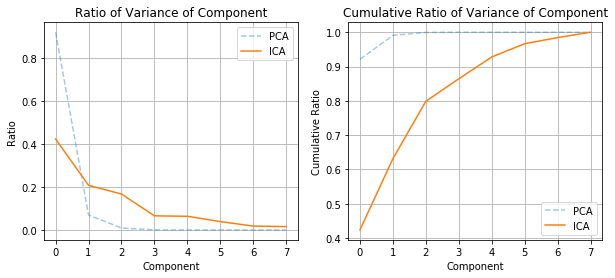

In [93]:
pca_var, ica_var = rnn_analysis.component_analysis(c_states[_id, burn_in:, :], 8)
rnn_analysis.plot_component_analysis(pca_var, ica_var)

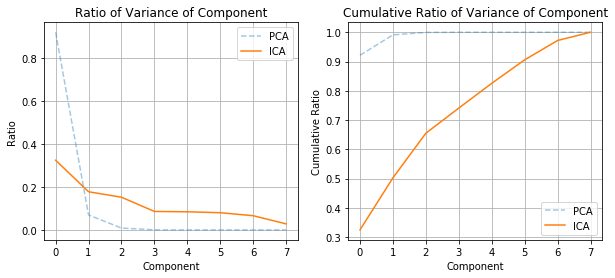

In [94]:
pca_var, ica_var = rnn_analysis.component_analysis(h_states[_id, burn_in:, :], 8)
rnn_analysis.plot_component_analysis(pca_var, ica_var)

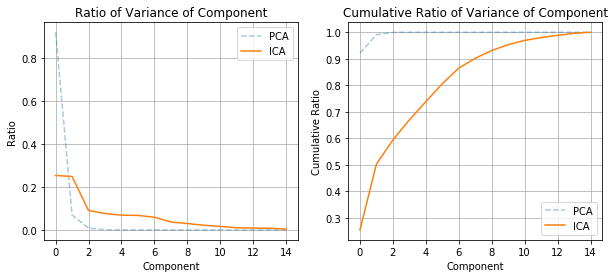

In [95]:
pca_var, ica_var = rnn_analysis.component_analysis(states[_id, burn_in:, :], 15)
rnn_analysis.plot_component_analysis(pca_var, ica_var)

## Baseline Explanation of Latent Variable

In [55]:
c_states.shape, svvol.shape

((5000, 999, 10), (5000, 1000))

In [57]:
for moment_order in [1, 2, 3, 4]:
    msg = f'Moment {moment_order}'
    
    lr = LinearRegression()
    states_ = (states[:, burn_in:, :]
               .reshape((-1, states.shape[2])))
    svvol_ = (svvol[:, (burn_in + 1):].ravel()
              ** moment_order)
    lr.fit(states_, svvol_)
    
    r2 = lr.score(states_, svvol_)
    msg += f' R2 {r2:.4f}'
    
    correl = stats.spearmanr(lr.predict(states_), svvol_)
    msg += f' Spearman R {correl}'
    print(msg)

Moment 1 R2 0.4406 Spearman R SpearmanrResult(correlation=0.6802265879489976, pvalue=0.0)
Moment 2 R2 0.4734 Spearman R SpearmanrResult(correlation=0.67981845658449469, pvalue=0.0)
Moment 3 R2 0.4091 Spearman R SpearmanrResult(correlation=0.67915129778254468, pvalue=0.0)
Moment 4 R2 0.2830 Spearman R SpearmanrResult(correlation=0.6776876058346617, pvalue=0.0)


In [200]:
rf = RandomForestRegressor(n_jobs=2)

In [201]:
_id = random.sample(range(states.shape[0]), 200)

In [202]:
rf.fit(states[_id, burn_in:, :].reshape((-1, states.shape[2])),
       (svvol[_id, (burn_in + 1):] ** 2).ravel())
rf.score(states[_id, burn_in:, :].reshape((-1, states.shape[2])),
         (svvol[_id, (burn_in + 1):] ** 2).ravel())

0.87911318043086673

In [203]:
stats.spearmanr(rf.predict(states[_id, burn_in:, :]
                           .reshape((-1, states.shape[2]))),
                (svvol[_id, (burn_in + 1):] ** 2).ravel())

SpearmanrResult(correlation=0.92166429827957252, pvalue=0.0)

# Quantile Regression

In [40]:
symbols_qtl, cell_qtl = tspred_qtl.train_lstm(sess, data[:, 0, :] * 10,
                                              features_func, targets_func,
                                              quantiles=[.5], burn_in=burn_in,
                                              batch_size=50,
                                              lr0=3e-3, lr_decay=(50, .99), n_iter=300,
                                              num_units=10, variable_scope='arima_qtl_2')

Iter 0 Train loss 0.3098 Dev loss 0.3065
Iter 5 Train loss 0.2865 Dev loss 0.2814
Iter 10 Train loss 0.2596 Dev loss 0.2537
Iter 15 Train loss 0.2315 Dev loss 0.2259
Iter 20 Train loss 0.2039 Dev loss 0.1980
Iter 25 Train loss 0.1753 Dev loss 0.1702
Iter 30 Train loss 0.1489 Dev loss 0.1429
Iter 35 Train loss 0.1209 Dev loss 0.1163
Iter 40 Train loss 0.0959 Dev loss 0.0912
Iter 45 Train loss 0.0729 Dev loss 0.0693
Iter 50 Train loss 0.0564 Dev loss 0.0543
Iter 55 Train loss 0.0479 Dev loss 0.0478
Iter 60 Train loss 0.0457 Dev loss 0.0460
Iter 65 Train loss 0.0457 Dev loss 0.0456
Iter 70 Train loss 0.0446 Dev loss 0.0455
Iter 75 Train loss 0.0451 Dev loss 0.0455
Iter 80 Train loss 0.0452 Dev loss 0.0455
Iter 85 Train loss 0.0457 Dev loss 0.0454
Iter 90 Train loss 0.0457 Dev loss 0.0454
Iter 95 Train loss 0.0452 Dev loss 0.0454
Iter 100 Train loss 0.0454 Dev loss 0.0454


In [41]:
cost, cost_no_noise, pred = tspred_qtl.eval_ar(sess, symbols_qtl,
                                               data_test * 10,
                                               features_func, targets_func,
                                               burn_in)
cost /= 10
cost_no_noise /= 10
pred /= 10
cost, cost_no_noise

(0.0045403551310300829, 0.0056395366677804391)

In [23]:
err = data_test[:, 1, 1:].squeeze() - pred.squeeze()

In [85]:
stats.describe(err[:, burn_in:].ravel())

DescribeResult(nobs=474500, minmax=(-0.037910406642100561, 0.033772045357841313), mean=0.0001720029847691188, variance=2.7081913907057125e-05, skewness=-0.7009503698677699, kurtosis=2.7840172075043643)

In [86]:
np.median(err[:, burn_in:].ravel())

0.00076345171612178227

In [89]:
stats.spearmanr(err[:, burn_in:].ravel(),
                data_test[:, 2, (burn_in + 1):].ravel())

SpearmanrResult(correlation=0.025934000807081328, pvalue=2.1191677715461647e-71)

In [90]:
stats.median_test(err[:, burn_in:].ravel(),
                  np.random.standard_normal(err[:, burn_in:].ravel().shape))

(1.7644214963119074,
 0.18407397232262196,
 0.00076967526981887953,
 array([[236926, 237574],
        [237574, 236926]]))

## RNN Internal Contents 

In [42]:
lstm_input = np.apply_along_axis(features_func, 1, data[:, 0, :])
lstm_output = np.apply_along_axis(targets_func, 1, data[:, 0, :])
lstm_input_test = np.apply_along_axis(features_func, 1, data_test[:, 0, :])
lstm_output_test = np.apply_along_axis(targets_func, 1, data_test[:, 0, :])
if lstm_input.ndim == 2:
    lstm_input = lstm_input[:, :, None]
    lstm_input_test = lstm_input_test[:, :, None]
if lstm_output.ndim == 2:
    lstm_output = lstm_output[:, :, None]
    lstm_output_test = lstm_output_test[:, :, None]
lstm_input.shape, lstm_output.shape

((5000, 999, 1), (5000, 999, 1))

In [43]:
c_states, h_states = rnn_analysis.lstm_states(sess, cell_qtl, lstm_input)
c_states_test, h_states_test = rnn_analysis.lstm_states(sess, cell_qtl, 
                                                        lstm_input_test)

In [44]:
states = np.concatenate([c_states, h_states], axis=2)
states_test = np.concatenate([c_states_test, h_states_test], axis=2)
states.shape

(5000, 999, 20)

In [94]:
_id = random.sample(range(states.shape[0]), 200)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


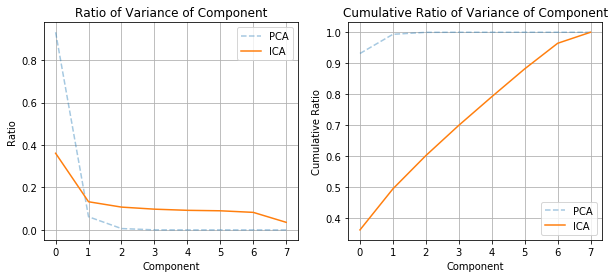

In [95]:
pca_var, ica_var = rnn_analysis.component_analysis(c_states[_id, burn_in:, :], 8)
rnn_analysis.plot_component_analysis(pca_var, ica_var)

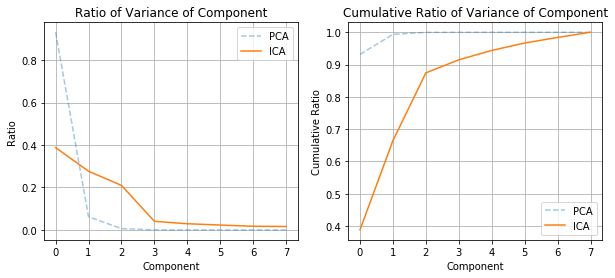

In [96]:
pca_var, ica_var = rnn_analysis.component_analysis(h_states[_id, burn_in:, :], 8)
rnn_analysis.plot_component_analysis(pca_var, ica_var)

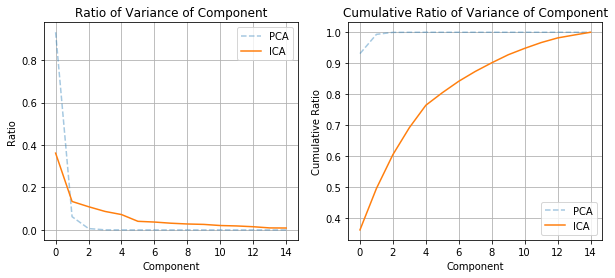

In [97]:
pca_var, ica_var = rnn_analysis.component_analysis(states[_id, burn_in:, :], 15)
rnn_analysis.plot_component_analysis(pca_var, ica_var)

## Baseline Explanation of Latent Variable 

In [23]:
c_states.shape, svvol.shape

((5000, 999, 10), (5000, 1000))

In [45]:
c_states.shape, rs_prob0.shape

((5000, 999, 10), (5000, 1000))

### By Linear Regression

If the latent state is continuous, we regress.

In [24]:
for moment_order in [4, 3, 2]:
    msg = f'Moment {moment_order}'
    
    lr = LinearRegression()
    states_ = (states[:, burn_in:, :]
               .reshape((-1, states.shape[2])))
    svvol_ = (svvol[:, (burn_in + 1):].ravel()
              ** moment_order)
    lr.fit(states_, svvol_)
    
    r2 = lr.score(states_, svvol_)
    msg += f' R2 {r2:.4f}'
    
    correl = stats.spearmanr(lr.predict(states_), svvol_)
    msg += f' Spearman R {correl}'
    print(msg)

Moment 4 R2 0.2856 Spearman R SpearmanrResult(correlation=0.708373809844136, pvalue=0.0)
Moment 3 R2 0.4318 Spearman R SpearmanrResult(correlation=0.71223529626045101, pvalue=0.0)
Moment 2 R2 0.5054 Spearman R SpearmanrResult(correlation=0.71480458573805283, pvalue=0.0)


Linear regressor for latent varianace:

In [25]:
lr.coef_, lr.intercept_

(array([ -8.19760513e+00,   1.78186447e+02,   3.17195630e+03,
          4.23209106e+02,   2.25974396e+02,  -2.57622070e+01,
          4.64212463e+02,   1.30404309e+03,  -9.52226105e+01,
          3.08754272e+02,   5.01048065e+02,   6.26886658e+02,
         -3.58676050e+03,  -6.60417099e+01,   7.63937622e+02,
         -7.40908752e+02,  -2.39230972e+02,  -2.62673926e+03,
         -1.88697189e+02,  -3.46960163e+00], dtype=float32), 615.74298)

Spearman correlation on each trajectory in the test set:

In [26]:
correl_test = [stats.spearmanr(lr.predict(s[burn_in:, :]),
                               vol[(burn_in + 1):]).correlation
               for s, vol in zip(states_test, svvol_test)] 

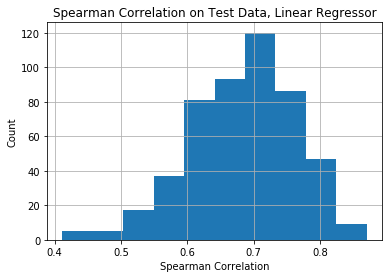

In [27]:
plt.hist(correl_test)
plt.grid()
plt.xlabel('Spearman Correlation')
plt.ylabel('Count')
plt.title('Spearman Correlation on Test Data, Linear Regressor')
plt.savefig('doc/hist-spearman-correl-lr.png')

If the latent state is categorical, we classify.

In [46]:
clf = SGDClassifier(loss='log', max_iter=1000)

In [47]:
_id = random.sample(range(states.shape[0]), 20)

In [48]:
clf.fit(states[_id, burn_in:, :]
        .reshape((-1, states.shape[2])),
        rs_regime[_id, (burn_in + 1):].ravel())

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [49]:
cross_entropy = [log_loss(g, 
                          1 / (1 + np.exp(- clf.decision_function(s))))
                 for g, s in zip(rs_regime_test[:, (burn_in + 1):], 
                                 states_test[:, burn_in:, :])]

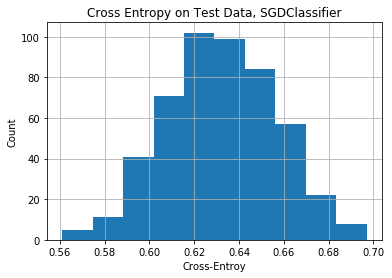

In [50]:
plt.hist(cross_entropy)
plt.grid()
plt.xlabel('Cross-Entroy')
plt.ylabel('Count')
plt.title('Cross Entropy on Test Data, SGDClassifier')
plt.savefig('doc/hist-ce-rs-lr.png')

In [51]:
accuracy = [clf.score(s, g)
                 for g, s in zip(rs_regime_test[:, (burn_in + 1):], 
                                 states_test[:, burn_in:, :])]

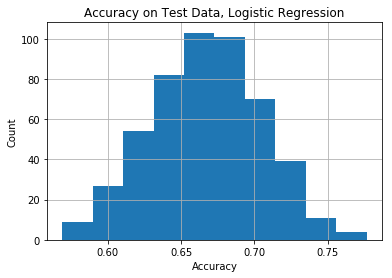

In [52]:
plt.hist(accuracy)
plt.grid()
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.title('Accuracy on Test Data, Logistic Regression')
plt.savefig('doc/hist-accu-rs-lr.png')

### By Random Forest

For continuous state,

In [28]:
rf_qtl = RandomForestRegressor(n_jobs=4, n_estimators=200)

For categorical state,

In [53]:
rf_qtl = RandomForestClassifier(n_jobs=4, n_estimators=200, criterion='entropy')

As there're about 1000 steps on each trajectory, this comes to 20k training samples.

In [54]:
_id = random.sample(range(states.shape[0]), 20)

In [31]:
# continuous latent state
states_ = states[_id, burn_in:, :].reshape((-1, states.shape[2]))
svvol_ = (svvol[_id, (burn_in + 1):] ** 2).ravel()

In [55]:
# discrete latent state
states_ = states[_id, burn_in:, :].reshape((-1, states.shape[2]))
regime_ = rs_regime[_id, (burn_in + 1):].ravel()

In [32]:
# continuous latent state
rf_qtl.fit(states_, svvol_)
rf_qtl.score(states_, svvol_)

0.91199177964064737

In [56]:
# discrete latent state
rf_qtl.fit(states_, regime_)
rf_qtl.score(states_, regime_)

1.0

In [33]:
# continuous latent state
stats.spearmanr(rf_qtl.predict(states_), svvol_)

SpearmanrResult(correlation=0.96370333188882629, pvalue=0.0)

In [57]:
# discrete latent state
log_loss(regime_, rf_qtl.predict_proba(states_)[:, 1])

0.14306098465174083

Spearman correlation on each trajectory in the test set:

In [35]:
# continuous latent state
correl_test = [stats.spearmanr(rf_qtl.predict(s[burn_in:, :]),
                               vol[(burn_in + 1):]).correlation
               for s, vol in zip(states_test, svvol_test)] 

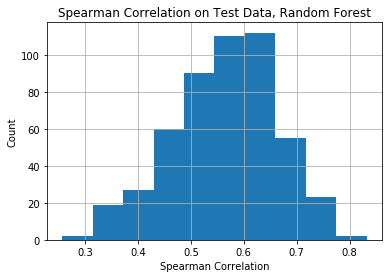

In [36]:
plt.hist(correl_test)
plt.grid()
plt.xlabel('Spearman Correlation')
plt.ylabel('Count')
plt.title('Spearman Correlation on Test Data, Random Forest')
plt.savefig('doc/hist-spearman-correl-rf.png')

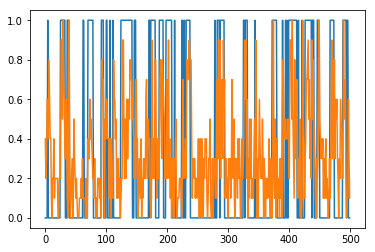

In [74]:
# discrete latent state
plt.plot(np.column_stack([rs_regime_test[27, -500:],
                          rf_qtl.predict_proba(states_test[27, -500:, :])[:, 1]]))

In [58]:
log_loss(rs_regime_test[27, (burn_in + 1):],
                          rf_qtl.predict_proba(states_test[27, burn_in:, :])[:, 1])

0.54997469664703502

In [50]:
rf_qtl.predict_proba(states_test[5, burn_in:, :]).sum(axis=0)

array([ 631.2,  317.8])

In [59]:
cross_entropy = [log_loss(g, rf_qtl.predict_proba(s)[:, 1])
                 for g, s in zip(rs_regime_test[:, (burn_in + 1):], 
                                 states_test[:, burn_in:, :])]

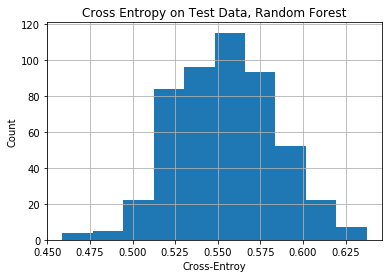

In [60]:
plt.hist(cross_entropy)
plt.grid()
plt.xlabel('Cross-Entroy')
plt.ylabel('Count')
plt.title('Cross Entropy on Test Data, Random Forest')
plt.savefig('doc/hist-ce-rs-rf.png')

In [61]:
accuracy = [rf_qtl.score(s, g)
                 for g, s in zip(rs_regime_test[:, (burn_in + 1):], 
                                 states_test[:, burn_in:, :])]

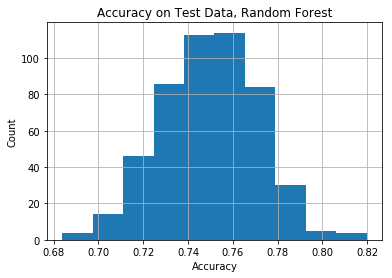

In [62]:
plt.hist(accuracy)
plt.grid()
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.title('Accuracy on Test Data, Random Forest')
plt.savefig('doc/hist-accu-rs-rf.png')

In [48]:
rf_qtl.feature_importances_

array([ 0.05994782,  0.04287165,  0.04743607,  0.05055097,  0.0580647 ,
        0.03973054,  0.04886598,  0.05374955,  0.04381645,  0.04157226,
        0.0536757 ,  0.04595425,  0.04416914,  0.05804232,  0.06895362,
        0.04131127,  0.0608472 ,  0.04779043,  0.05124232,  0.04140777])

In [180]:
sess.close()

# Bayesian Fitting

In [12]:
spec = """
data {
    int K;
    int J;
    vector[K] a[J];
}
parameters {
    vector[2] ar;
    vector[2] ma;
    real<lower = 1e-2> sigma;
}
transformed parameters {
    vector[K] eps[J];
    eps[1] = a[1];
    eps[2] = a[2] - ar[1] * a[1] - ma[1] * eps[1];
    for (j in 3:J)
        eps[j] = a[j] - ar[1] * a[j - 1] - ar[2] * a[j - 2]
            - ma[1] * eps[j - 1] - ma[2] * eps[j - 2];
}
model {
    ar ~ normal(0, 5);
    ma ~ normal(0, 5);
    sigma ~ inv_gamma(1, .2);
    
    for (j in 1:J)
        eps[j] ~ normal(0, sqrt(sigma / 255));
}
"""

In [13]:
bayesmodel = pystan.StanModel(model_code=spec)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_de986b781f270d9b3aeedc9e661c237d NOW.


In [16]:
bayesmodel_data = {'K': 5, 'J': simulation.shape[2],
                   'a': simulation[random.sample(range(simulation.shape[0]), 5), 0].T}

fit = bayesmodel.sampling(data=bayesmodel_data, iter=2000, chains=4)

LinAlgError: singular matrix

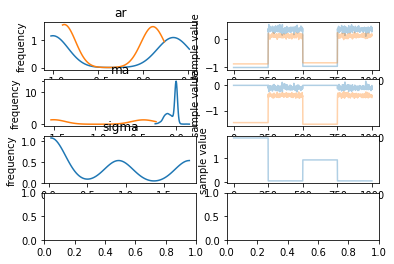

In [17]:
fit.plot()

In [18]:
print(fit)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Inference for Stan model: anon_model_de986b781f270d9b3aeedc9e661c237d.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ar[0]       -0.33    0.47   0.67  -1.02   -1.0  -0.45   0.34   0.44      2  15.86
ar[1]       -0.38    0.35   0.49   -0.9  -0.88  -0.44   0.11   0.19      2  16.35
ma[0]       -0.05    0.04   0.06  -0.19   -0.1 1.5e-3 1.6e-3   0.01      3   1.53
ma[1]       -0.95    0.39   0.56  -1.54  -1.51   -1.0   -0.4  -0.31      2  17.19
sigma         0.7    0.53   0.74   0.03   0.03   0.47   1.41   1.83      2    nan
eps[0,0]      0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   1000    nan
eps[1,0]      0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   1000    nan
eps[2,0]    -0.01 1.2e-181.7e-18  -0.01  -0.01  -0.01  -0.01  -0.01      2    nan
eps[3,0]   4.4e-3  5.4e-3 7.6e-3-3.5e-3-3.3e-3 4.3e-3   0.01   0.01      2  